![image](https://www.ewatercycle.org/img/logo.png)

# MARRMoT-m14 TOPMODEL - a test notebook for calibration and running
This notebooks calibrates and runs the MARRMoT-m14 model for a single catchment and a single forcing dataset. The output cannot be trusted because this testrun is meant to illustrate the workflow.
Specific settings for this test run include the catchment, corresponding station ID, forcing dataset, a parameter range with large step size and the number of days to spinup and run the model instead of the full period.

More detailed information about the specific setup required to reproduce this analysis is available in the [ReadMe](https://github.com/eWaterCycle/era5-comparison/blob/master/marrmot-m14/README.md).

## Import statements
We'll be using the following modules:

In [10]:
import os
import time
from datetime import datetime
from pathlib import Path

import hydrostats.metrics as hm
import hydrostats.visual as hv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import xarray as xr
from cartopy.io import shapereader
from cftime import num2date
from ewatercycle.observation.grdc import get_grdc_data
from grpc4bmi.bmi_client_singularity import BmiClientSingularity
from tqdm import tqdm
import cma

## General settings
The cell below defines all the settings for the comparison study. Note that we use capitals for 'global' variables. This is not strictly necessary, but it makes them very recognizable later on in the notebook. Particularly, we sometimes reference these variables from inside functions, without passing them explicitly as function arguments.

In [11]:
# The project home directory where data lives and output should be written
PROJECT_HOME = Path("/projects/0/wtrcycle/comparison/")

# The location where this notebook will put a timestamped temp dir
TEMP_LOC = Path("/scratch/shared/ewatercycle/")

# forcing dataset and directory
# Note: forcing data are the same for different marrmot models
FORCING_DIR = PROJECT_HOME / "forcing" / "marrmot-m01"

# catchments and corresponding GRDC station ID
dataset = "ERA-Interim"
catchment = "Rhine"
station_id = "6335020"

# test period for both validation and calibration (Year, Month, Date)
PERIOD = {
    "spinup": datetime(2001, 1, 1),
    "start": datetime(2001, 2, 1),
    "end": datetime(2001, 12, 31),
}

# flux_out_Q unit conversion factor from mm/day to m3/s
conversion = 1 / (1000 * 86400)

In [12]:
# add a timestamped directory to the main tempdir
TEMP_DIR = TEMP_LOC / f"marrmot-m14_{time.strftime('%Y%m%d_%H%M%S')}"
TEMP_DIR.mkdir(parents=True, exist_ok=True)
print(TEMP_DIR)

/scratch/shared/ewatercycle/marrmot-m14_20210128_134835


## Functions for the model run and calibration

To calibrate the model, we need to run the model several times, with different parameter settings. To do so, we defined some functions for: writing a specific config file, initializing a singularity image and running the model for given period.

The function `objective_function()` can be used as first argument to the optimization methods. As optimization metric we use that Nash–Sutcliffe model efficiency coefficient (NSE), comparing the model output with GRDC data. NSE values range between `-inf < NSE < 1` with close to 1 indicating a good match, while the optimization expects the closer to zero the better. Therefore we use the value `1 - nse_value` as objective function.

In [13]:
def write_config(parameters, catchment, forcing):
    """Write model configuration file.

    Adds the model parameters to forcing file for the given period
    and catchment including the spinup year and writes this information
    to a model configuration file.
    """
    # get the forcing that was created with ESMValTool
    forcing_file = f"marrmot-m01_{forcing}_{catchment}_{PERIOD['spinup'].year}_{PERIOD['end'].year}.mat"
    forcing_data = sio.loadmat(FORCING_DIR / forcing_file, mat_dtype=True)

    # select forcing data
    forcing_data["time_end"][0][0:3] = [
        PERIOD["end"].year,
        PERIOD["end"].month,
        PERIOD["end"].day,
    ]

    suzmax = parameters[0]
    # combine forcing and model parameters
    forcing_data.update(
        model_name="m_14_topmodel_7p_2s",
        parameters=parameters,
        solver={
            "name": "createOdeApprox_IE",  # IE:Implicit Euler.
            "resnorm_tolerance": float(0.1),
            "resnorm_maxiter": float(6),
        },
        store_ini=[0.9 * suzmax, 0.9 * suzmax],  # 90% of suzmax
    )

    # save as new configuration file
    config_file = TEMP_DIR / (
        f"config_marrmot-m01_{forcing}_{catchment}_{PERIOD['spinup'].year}_{PERIOD['end'].year}.mat"
    )
    sio.savemat(config_file, forcing_data)
    return config_file


def run_model(parameters, catchment, forcing, variable, test=False):
    """Run model using Singularity image."""
    config_name = write_config(parameters, catchment, forcing)
    model = BmiClientSingularity(
        image="ewatercycle-marrmot-grpc4bmi.sif", input_dir=".", output_dir="."
    )
    model.initialize(config_name)

    # Check available variables
    if test:
        print("Model variable names:", model.get_output_var_names())

    # Get time information
    time_units = model.get_time_units()
    spinup = num2date(model.get_start_time(), time_units)
    end = num2date(model.get_end_time(), time_units)

    # Get space information
    grid = model.get_var_grid(variable)
    lat = model.get_grid_x(grid)[0]
    lon = model.get_grid_y(grid)[0]

    time_range = pd.date_range(
        spinup.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")
    )
    desc = f"Running with parameters:{parameters}"
    variable_overtime = []
    variable_time = []
    for current_time in tqdm(time_range, desc=desc):
        # Store model time and variable output after the spin up period
        if current_time >= PERIOD["start"]:
            now = num2date(
                model.get_current_time(),
                time_units,
                only_use_cftime_datetimes=False
            )
            value = model.get_value(variable)[0]
            variable_overtime.append(value)
            variable_time.append(now.strftime("%Y-%m-%d"))
        model.update()
    model.finalize()
    # Store output as a data array
    da = xr.DataArray(
        np.array(variable_overtime),
        coords={
            "longitude": lon,
            "latitude": lat,
            "time": np.array(variable_time)
        },
        dims=["time"],
        name=variable,
        attrs={"units": model.get_var_units(variable)},
    )
    del model
    return da


def objective_function(parameters, catchment, forcing, observations, area, conversion):
    """Calculate objective function.

    Runs the model, converts the output to GRDC streamflow units
    and calculates NSE from simulation data with observation data.
    This is the function that is going to be optimized by scipy.brute.
    """
    simulations = run_model(parameters, catchment, forcing, "flux_out_Q")

    # convert simulated streamflow to same units as observation
    simulations = simulations.values * area * conversion
    nse_value = hm.nse(simulations, observations)
    print(f"-----objective function value (1-NSE): {1 - nse_value}-----")
    return 1 - nse_value


## Run the model for a couple of time steps (before calibration)

In [14]:
# Let's analyse discharge
variable = "flux_out_Q"

# ranges can be found at:
# https://github.com/wknoben/MARRMoT/blob/dev-docker-BMI/MARRMoT/Models/Parameter%20range%20files
parameters = [float(100.0),  # suzmax, Maximum soil moisture storage in unsatured zone [mm]
              float(0.05),  # st, Threshold for flow generation and evap change as fraction of suzmax [-]
              float(0.0),   # kd, Leakage to saturated zone flow coefficient [mm/d]
              float(0.1),   # q0, Zero deficit base flow speed [mm/d]
              float(0.0),   # m, Baseflow coefficient [mm-1]
              float(1.0),   # chi, Gamma distribution parameter [-]
              float(0.1)]   # phi, Gamma distribution parameter [-]


# when test is true, it prints the model variable names
simulations = run_model(parameters, catchment, dataset, variable, test=True)

Running with parameters:[100.0, 0.05, 0.0, 0.1, 0.0, 1.0, 0.1]:   0%|          | 0/365 [00:00<?, ?it/s]

Model variable names: ('P', 'T', 'Ep', 'S(t)', 'par', 'sol_resnorm_tolerance', 'sol_resnorm_maxiter', 'flux_out_Q', 'flux_out_Ea', 'wb')


Running with parameters:[100.0, 0.05, 0.0, 0.1, 0.0, 1.0, 0.1]: 100%|██████████| 365/365 [00:39<00:00,  9.32it/s]


## Get the catchment area in m2 to be used in calibration and comparison

In [15]:
# project directories for model input i.e. shape files and forcing
SHAPE_DIR = (
    PROJECT_HOME / "recipes_auxiliary_datasets" / "Lorentz_Basin_Shapefiles"
)
shapefile = SHAPE_DIR / catchment / f"{catchment}.shp"
shape = shapereader.Reader(shapefile)
attr = next(shape.records())
area = attr.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", area)

The catchment area is: 163122500000.0


## Get GRDC observation data to be used in calibration and comparison

In [16]:
# add GRDC directory to environment variables
os.environ["GRDC_DATA_HOME"] = str(
    PROJECT_HOME / "GRDC" / "GRDC_GCOSGTN-H_27_03_2019"
)

observations_ds = get_grdc_data(
    station_id,
    PERIOD['start'].strftime('%Y-%m-%d'),
    PERIOD['end'].strftime('%Y-%m-%d'),
)

## Calibration

We use the [CMA Evolution Strategy (CMA-ES) algorithm](https://github.com/CMA-ES/pycma) package.
The CMA-ES is initialized with:

 - initial value (mean) x0 = 7 * [5], here 7 is the number of variables, 5 is the mean value in range [0, 10].
 - initial step size (standard deviation) sigma0=0.1.
 - options

The values for `bounds: [0,10]` and  `sigma0=0.1` are chosen based on the guides in
[practical hints](http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical),
see sections **Encoding of Variables** and **Initial Values**.
The `bounds` are used to make the `transform` function, see below.

PARAMETERS_BOUNDS are copied from
https://github.com/wknoben/MARRMoT/blob/dev-docker-BMI/MARRMoT/Models/Parameter%20range%20files.

- suzmax, Maximum soil moisture storage in unsatured zone [mm]:(1, 2000)
- st, Threshold for flow generation and evap change as fraction of suzmax [-]: (0.05, 0.95)
- kd, Leakage to saturated zone flow coefficient [mm/d]: (0, 1)
- q0, Zero deficit base flow speed [mm/d]: (0.1, 200)
- m, Baseflow coefficient [mm-1]: (0, 1)
- chi, Gamma distribution parameter [-]: (1, 7.5)
- phi, Gamma distribution parameter [-]: (0.1, 5)

In [17]:
# Set some options for optimization
options = cma.CMAOptions()
options.set({
    'bounds': [0, 10],  # for scaled parameters
    'maxiter': 3,
    'seed': 1234,  # set a seed to reproduce results
#     'tolfun': 1e-1,
#     'tolfunrel': 1e-2,
#     'tolx': 1e-2,
})

# M14 parameter bounds
PARAMETERS_BOUNDS = [[1.0, 2000.0],  # suzmax, Maximum soil moisture storage in unsatured zone [mm]
                     [0.05, 0.95],  # st, Threshold for flow generation and evap change as fraction of suzmax [-]
                     [0.0, 1.0],   # kd, Leakage to saturated zone flow coefficient [mm/d]
                     [0.1, 200.0],   # q0, Zero deficit base flow speed [mm/d]
                     [0.0, 1.0],   # m, Baseflow coefficient [mm-1]
                     [1.0, 7.5],   # chi, Gamma distribution parameter [-]
                     [0.1, 5.0]]   # phi, Gamma distribution parameter [-]

no_of_variables = len(PARAMETERS_BOUNDS)
x0 = 5.0  # initial mean value
sigma0 = 0.1  # initial standard deviation

# Input arguments of the objective function
args = (catchment, dataset, observations_ds["streamflow"], area, conversion)

### Functions used by CMA-ES

In [18]:
def transform(scaled_parameters):
    """Transforms the scaled_parameter to parameter.

    if x = scaled_parameter and y = parameter,
    then x is in the range [0, 10] and y is in the range [a, b].
    To map the values [0, 10] into [a, b], we use the transformations a + (b-a) * x/10.
    For more information on this transformation,
    please see http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical
    """
    parameters = []
    for scaled_parameter, bound in zip(scaled_parameters, PARAMETERS_BOUNDS):
        parameter = bound[0] + ((bound[1] - bound[0]) * (scaled_parameter / 10))
        parameters.append(parameter)
    return parameters


def wrapped_objective_function(scaled_parameters, *args):
    """A wrapper around the objective function.

    The wrapper transforms the scaled_parameters before the actual function call.
    """
    parameters = transform(scaled_parameters)
    return objective_function(parameters, *args)

### A test run of CMA-ES optimization method

In [19]:
# Initialize the CMA-ES
cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)

exec_start_time = time.time()
# Run the optimization
# Below, in each iteration, the objective function is evaluated 9 times.
# Here, 9 is the population size = 4+np.floor(3*np.log(no_of_variables=7))
optimization = cma_es.optimize(wrapped_objective_function, args=args)
print(f"Calibration completed in {time.time() - exec_start_time} seconds")
print("----------------------------------")

# Return the optimum scaled parameters and its objective value
print(f"optimum scaled parameters: {optimization.result.xbest}, its objective value (1-NSE): {optimization.result.fbest}")

# Return the optimum parameters
parameters = transform(optimization.result.xbest)
print(f"optimum parameters: {parameters}")

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=1234, Thu Jan 28 13:53:15 2021)


Running with parameters:[1009.9239889230125, 0.4892811421846451, 0.514327274358147, 99.42499546690188, 0.49279390678091345, 4.307667650642177, 2.5921216374465046]: 100%|██████████| 365/365 [00:30<00:00, 12.09it/s]


-----objective function value (1-NSE): 4.593690325431944-----


Running with parameters:[987.7758951466973, 0.5001412683580859, 0.47757283007229256, 102.34897067684446, 0.5099197436406249, 4.311968281440697, 2.450954269084366]: 100%|██████████| 365/365 [00:29<00:00, 12.20it/s]


-----objective function value (1-NSE): 4.6876848176998305-----


Running with parameters:[993.8217934574961, 0.5000190654183324, 0.5040545920380316, 100.62790717361155, 0.5132119594004556, 4.149447547945225, 2.5400699045267694]: 100%|██████████| 365/365 [00:30<00:00, 12.11it/s]


-----objective function value (1-NSE): 4.628707797117966-----


Running with parameters:[987.3871728106628, 0.501740804822509, 0.5055344681728338, 102.68504142137442, 0.49530681306380125, 4.2939125838115135, 2.4609618500581374]: 100%|██████████| 365/365 [00:30<00:00, 12.04it/s]


-----objective function value (1-NSE): 4.632888617986894-----


Running with parameters:[996.8396602818219, 0.5095307907649742, 0.49602154088327577, 100.72455232411214, 0.5104760850413668, 4.317988414730108, 2.5923239611377378]: 100%|██████████| 365/365 [00:29<00:00, 12.25it/s]


-----objective function value (1-NSE): 4.6464410470722886-----


Running with parameters:[998.0593894187949, 0.5011224246012038, 0.496772005830044, 101.73254380540308, 0.5239102882959653, 4.25495315010448, 2.522242959845273]: 100%|██████████| 365/365 [00:28<00:00, 12.72it/s]


-----objective function value (1-NSE): 4.638592464626087-----


Running with parameters:[1001.2224773143147, 0.48132506820189613, 0.5024779573966239, 98.25654515714159, 0.4986320125825901, 4.251188839895509, 2.587016871540866]: 100%|██████████| 365/365 [00:29<00:00, 12.21it/s]


-----objective function value (1-NSE): 4.615602193748815-----


Running with parameters:[1004.8032189335792, 0.5075691332194266, 0.4855416926837849, 97.24739535510945, 0.49899078916632755, 4.214362968074441, 2.542913340382425]: 100%|██████████| 365/365 [00:29<00:00, 12.30it/s]


-----objective function value (1-NSE): 4.658762925819338-----


Running with parameters:[1007.5768664406629, 0.4996803804895083, 0.5056574638809612, 103.13983816055482, 0.49025735830511213, 4.2454274196847095, 2.5650911206540408]: 100%|██████████| 365/365 [00:29<00:00, 12.26it/s]


-----objective function value (1-NSE): 4.613700652780933-----
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.593690325431944e+00 1.0e+00 9.57e-02  9e-02  1e-01 5:20.9


Running with parameters:[983.6725465684921, 0.5098563074684377, 0.49769382351197544, 98.53732165371473, 0.4896542162786872, 4.3890714512564575, 2.603731015975923]: 100%|██████████| 365/365 [00:28<00:00, 12.75it/s]


-----objective function value (1-NSE): 4.655893680197556-----


Running with parameters:[979.2678329288823, 0.49177164546277163, 0.5184499971502734, 98.61348719747113, 0.5070919949240168, 4.311772122569997, 2.547104218996112]: 100%|██████████| 365/365 [00:29<00:00, 12.51it/s]


-----objective function value (1-NSE): 4.614475135469166-----


Running with parameters:[998.6684046570928, 0.5038907449627629, 0.5240404120808286, 97.97903252491339, 0.5034016164976018, 4.4239583055101885, 2.4958458233876417]: 100%|██████████| 365/365 [00:28<00:00, 12.62it/s]


-----objective function value (1-NSE): 4.5952560537291145-----


Running with parameters:[976.0650653475954, 0.4862427185267883, 0.5131235484499032, 99.14848416382964, 0.49506755249607365, 4.249050610197896, 2.5645988083386815]: 100%|██████████| 365/365 [00:29<00:00, 12.22it/s]


-----objective function value (1-NSE): 4.622824016910891-----


Running with parameters:[996.4833017062806, 0.49383038818772174, 0.5000051404972294, 100.93023573154095, 0.4877542499936244, 4.285840999466485, 2.543780005536867]: 100%|██████████| 365/365 [00:29<00:00, 12.55it/s]


-----objective function value (1-NSE): 4.630035496405791-----


Running with parameters:[987.3381529857178, 0.4892065978513976, 0.5047903709792074, 101.66220675722151, 0.4978361659088469, 4.269025171705042, 2.5554292985930207]: 100%|██████████| 365/365 [00:29<00:00, 12.36it/s]


-----objective function value (1-NSE): 4.627608629542087-----


Running with parameters:[1000.2106803951151, 0.48452136201549845, 0.5162131208518207, 96.62553033431763, 0.4782282171911635, 4.348692331868522, 2.5741329435024167]: 100%|██████████| 365/365 [00:30<00:00, 11.97it/s]


-----objective function value (1-NSE): 4.5971661923255605-----


Running with parameters:[1021.4988548025897, 0.4963535554784408, 0.5057327094304174, 103.46867559701002, 0.4916600006891657, 4.270619968790682, 2.624462713854661]: 100%|██████████| 365/365 [00:30<00:00, 12.00it/s]


-----objective function value (1-NSE): 4.600095559693888-----


Running with parameters:[1031.5796900086432, 0.49651637708887975, 0.5011860921235701, 102.01422903241956, 0.487642038992958, 4.233471873118017, 2.590657008139872]: 100%|██████████| 365/365 [00:29<00:00, 12.25it/s]


-----objective function value (1-NSE): 4.599055929228163-----
    2     18 4.595256053729114e+00 1.2e+00 1.02e-01  1e-01  1e-01 10:40.1


Running with parameters:[1018.1991326131035, 0.4928868188031771, 0.523634253688787, 97.98396854638784, 0.49960142003336366, 4.419886624618609, 2.539084309215864]: 100%|██████████| 365/365 [00:29<00:00, 12.38it/s]


-----objective function value (1-NSE): 4.575800882229328-----


Running with parameters:[943.6321480342649, 0.5059758169553372, 0.5144667659784313, 94.27963624881686, 0.496375888104886, 4.395081334572577, 2.464433884222239]: 100%|██████████| 365/365 [00:29<00:00, 12.31it/s]


-----objective function value (1-NSE): 4.660630364637775-----


Running with parameters:[975.9347094989952, 0.4950670140000526, 0.5193691309056724, 97.44281296223556, 0.5034339723889263, 4.407564614840783, 2.5216012247178594]: 100%|██████████| 365/365 [00:29<00:00, 12.23it/s]


-----objective function value (1-NSE): 4.617431661179221-----


Running with parameters:[997.5191264427814, 0.4966159438199433, 0.5107276834436453, 99.81524980835015, 0.5149169523789153, 4.43636744824145, 2.5613487635679273]: 100%|██████████| 365/365 [00:30<00:00, 12.15it/s]


-----objective function value (1-NSE): 4.612695391681565-----


Running with parameters:[996.7190440261717, 0.49334647500920364, 0.5167124380888682, 99.06930546020091, 0.472434217987274, 4.3711726863384275, 2.4559708651596353]: 100%|██████████| 365/365 [00:29<00:00, 12.18it/s]


-----objective function value (1-NSE): 4.602863127980939-----


Running with parameters:[998.0395563838506, 0.49072470775032895, 0.5243250951825681, 97.42538951745132, 0.48437784575374526, 4.323377710973583, 2.5485801077386063]: 100%|██████████| 365/365 [00:29<00:00, 12.17it/s]


-----objective function value (1-NSE): 4.59025800184366-----


Running with parameters:[993.5090035387781, 0.5140930215830646, 0.5148498605032381, 99.24066778837255, 0.49016180249403485, 4.385435473540147, 2.5167451968136128]: 100%|██████████| 365/365 [00:29<00:00, 12.31it/s]


-----objective function value (1-NSE): 4.618584716141258-----


Running with parameters:[975.2613418792375, 0.5180338157033365, 0.5047733017511538, 96.04888729744714, 0.5061353930869417, 4.247443727154635, 2.5822836847930772]: 100%|██████████| 365/365 [00:29<00:00, 12.21it/s]


-----objective function value (1-NSE): 4.655889022942493-----


Running with parameters:[982.8352595608126, 0.5073847734609039, 0.5228235484863311, 101.73054889851736, 0.49542642580513296, 4.359288630871857, 2.57071927850019]: 100%|██████████| 365/365 [00:30<00:00, 11.87it/s]


-----objective function value (1-NSE): 4.612000704895243-----
    3     27 4.575800882229328e+00 1.4e+00 1.04e-01  9e-02  1e-01 16:01.4
Calibration completed in 961.4333384037018 seconds
----------------------------------
optimum scaled parameters: [5.08853993 4.92096465 5.23634254 4.89664675 4.9960142  5.26136404
 4.97772308], its objective value (1-NSE): 4.575800882229328
optimum parameters: [1018.1991326131035, 0.4928868188031771, 0.523634253688787, 97.98396854638784, 0.49960142003336366, 4.419886624618609, 2.539084309215864]


### A test run of CMA-ES optimization method storing each iteration

In [20]:
# Initialize the CMA-ES
cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)

# Store the results of each iteration
optimization_full_output = []

exec_start_time = time.time()
# Use ask-and-tell interface, see an example at https://pypi.org/project/cma/
while not cma_es.stop():
    solutions = cma_es.ask()
    evaluations = [wrapped_objective_function(x, *args) for x in solutions]
    cma_es.tell(solutions, evaluations)
    optimization_full_output.append([(cma_es.best.last.f, cma_es.best.last.x)])
print(f"Calibration completed in {time.time() - exec_start_time} seconds")
print("----------------------------------")

print(optimization_full_output)

# Return the optimum scaled parameters and its objective value
print(f"optimum scaled parameters: {cma_es.result.xbest}, its objective value (1-NSE): {cma_es.result.fbest}")

# Return the optimum parameters
parameters = transform(cma_es.result.xbest)
print(f"optimum parameters: {parameters}")

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=1234, Thu Jan 28 14:14:40 2021)


Running with parameters:[1009.9239889230125, 0.4892811421846451, 0.514327274358147, 99.42499546690188, 0.49279390678091345, 4.307667650642177, 2.5921216374465046]: 100%|██████████| 365/365 [00:29<00:00, 12.30it/s]


-----objective function value (1-NSE): 4.593690325431944-----


Running with parameters:[987.7758951466973, 0.5001412683580859, 0.47757283007229256, 102.34897067684446, 0.5099197436406249, 4.311968281440697, 2.450954269084366]: 100%|██████████| 365/365 [00:29<00:00, 12.31it/s]


-----objective function value (1-NSE): 4.6876848176998305-----


Running with parameters:[993.8217934574961, 0.5000190654183324, 0.5040545920380316, 100.62790717361155, 0.5132119594004556, 4.149447547945225, 2.5400699045267694]: 100%|██████████| 365/365 [00:29<00:00, 12.27it/s]


-----objective function value (1-NSE): 4.628707797117966-----


Running with parameters:[987.3871728106628, 0.501740804822509, 0.5055344681728338, 102.68504142137442, 0.49530681306380125, 4.2939125838115135, 2.4609618500581374]: 100%|██████████| 365/365 [00:29<00:00, 12.29it/s]


-----objective function value (1-NSE): 4.632888617986894-----


Running with parameters:[996.8396602818219, 0.5095307907649742, 0.49602154088327577, 100.72455232411214, 0.5104760850413668, 4.317988414730108, 2.5923239611377378]: 100%|██████████| 365/365 [00:30<00:00, 12.13it/s]


-----objective function value (1-NSE): 4.6464410470722886-----


Running with parameters:[998.0593894187949, 0.5011224246012038, 0.496772005830044, 101.73254380540308, 0.5239102882959653, 4.25495315010448, 2.522242959845273]: 100%|██████████| 365/365 [00:30<00:00, 12.16it/s]


-----objective function value (1-NSE): 4.638592464626087-----


Running with parameters:[1001.2224773143147, 0.48132506820189613, 0.5024779573966239, 98.25654515714159, 0.4986320125825901, 4.251188839895509, 2.587016871540866]: 100%|██████████| 365/365 [00:29<00:00, 12.29it/s]


-----objective function value (1-NSE): 4.615602193748815-----


Running with parameters:[1004.8032189335792, 0.5075691332194266, 0.4855416926837849, 97.24739535510945, 0.49899078916632755, 4.214362968074441, 2.542913340382425]: 100%|██████████| 365/365 [00:29<00:00, 12.17it/s]


-----objective function value (1-NSE): 4.658762925819338-----


Running with parameters:[1007.5768664406629, 0.4996803804895083, 0.5056574638809612, 103.13983816055482, 0.49025735830511213, 4.2454274196847095, 2.5650911206540408]: 100%|██████████| 365/365 [00:29<00:00, 12.38it/s]


-----objective function value (1-NSE): 4.613700652780933-----


Running with parameters:[983.6725465684921, 0.5098563074684377, 0.49769382351197544, 98.53732165371473, 0.4896542162786872, 4.3890714512564575, 2.603731015975923]: 100%|██████████| 365/365 [00:29<00:00, 12.24it/s]


-----objective function value (1-NSE): 4.655893680197556-----


Running with parameters:[979.2678329288823, 0.49177164546277163, 0.5184499971502734, 98.61348719747113, 0.5070919949240168, 4.311772122569997, 2.547104218996112]: 100%|██████████| 365/365 [00:29<00:00, 12.24it/s]


-----objective function value (1-NSE): 4.614475135469166-----


Running with parameters:[998.6684046570928, 0.5038907449627629, 0.5240404120808286, 97.97903252491339, 0.5034016164976018, 4.4239583055101885, 2.4958458233876417]: 100%|██████████| 365/365 [00:29<00:00, 12.27it/s]


-----objective function value (1-NSE): 4.5952560537291145-----


Running with parameters:[976.0650653475954, 0.4862427185267883, 0.5131235484499032, 99.14848416382964, 0.49506755249607365, 4.249050610197896, 2.5645988083386815]: 100%|██████████| 365/365 [00:29<00:00, 12.24it/s]


-----objective function value (1-NSE): 4.622824016910891-----


Running with parameters:[996.4833017062806, 0.49383038818772174, 0.5000051404972294, 100.93023573154095, 0.4877542499936244, 4.285840999466485, 2.543780005536867]: 100%|██████████| 365/365 [00:29<00:00, 12.24it/s]


-----objective function value (1-NSE): 4.630035496405791-----


Running with parameters:[987.3381529857178, 0.4892065978513976, 0.5047903709792074, 101.66220675722151, 0.4978361659088469, 4.269025171705042, 2.5554292985930207]: 100%|██████████| 365/365 [00:29<00:00, 12.37it/s]


-----objective function value (1-NSE): 4.627608629542087-----


Running with parameters:[1000.2106803951151, 0.48452136201549845, 0.5162131208518207, 96.62553033431763, 0.4782282171911635, 4.348692331868522, 2.5741329435024167]: 100%|██████████| 365/365 [00:29<00:00, 12.27it/s]


-----objective function value (1-NSE): 4.5971661923255605-----


Running with parameters:[1021.4988548025897, 0.4963535554784408, 0.5057327094304174, 103.46867559701002, 0.4916600006891657, 4.270619968790682, 2.624462713854661]: 100%|██████████| 365/365 [00:29<00:00, 12.25it/s]


-----objective function value (1-NSE): 4.600095559693888-----


Running with parameters:[1031.5796900086432, 0.49651637708887975, 0.5011860921235701, 102.01422903241956, 0.487642038992958, 4.233471873118017, 2.590657008139872]: 100%|██████████| 365/365 [00:30<00:00, 12.12it/s]


-----objective function value (1-NSE): 4.599055929228163-----


Running with parameters:[1018.1991326131035, 0.4928868188031771, 0.523634253688787, 97.98396854638784, 0.49960142003336366, 4.419886624618609, 2.539084309215864]: 100%|██████████| 365/365 [00:29<00:00, 12.45it/s]


-----objective function value (1-NSE): 4.575800882229328-----


Running with parameters:[943.6321480342649, 0.5059758169553372, 0.5144667659784313, 94.27963624881686, 0.496375888104886, 4.395081334572577, 2.464433884222239]: 100%|██████████| 365/365 [00:29<00:00, 12.18it/s]


-----objective function value (1-NSE): 4.660630364637775-----


Running with parameters:[975.9347094989952, 0.4950670140000526, 0.5193691309056724, 97.44281296223556, 0.5034339723889263, 4.407564614840783, 2.5216012247178594]: 100%|██████████| 365/365 [00:30<00:00, 12.09it/s]


-----objective function value (1-NSE): 4.617431661179221-----


Running with parameters:[997.5191264427814, 0.4966159438199433, 0.5107276834436453, 99.81524980835015, 0.5149169523789153, 4.43636744824145, 2.5613487635679273]: 100%|██████████| 365/365 [00:29<00:00, 12.17it/s]


-----objective function value (1-NSE): 4.612695391681565-----


Running with parameters:[996.7190440261717, 0.49334647500920364, 0.5167124380888682, 99.06930546020091, 0.472434217987274, 4.3711726863384275, 2.4559708651596353]: 100%|██████████| 365/365 [00:29<00:00, 12.35it/s]


-----objective function value (1-NSE): 4.602863127980939-----


Running with parameters:[998.0395563838506, 0.49072470775032895, 0.5243250951825681, 97.42538951745132, 0.48437784575374526, 4.323377710973583, 2.5485801077386063]: 100%|██████████| 365/365 [00:29<00:00, 12.17it/s]


-----objective function value (1-NSE): 4.59025800184366-----


Running with parameters:[993.5090035387781, 0.5140930215830646, 0.5148498605032381, 99.24066778837255, 0.49016180249403485, 4.385435473540147, 2.5167451968136128]: 100%|██████████| 365/365 [00:29<00:00, 12.23it/s]


-----objective function value (1-NSE): 4.618584716141258-----


Running with parameters:[975.2613418792375, 0.5180338157033365, 0.5047733017511538, 96.04888729744714, 0.5061353930869417, 4.247443727154635, 2.5822836847930772]: 100%|██████████| 365/365 [00:29<00:00, 12.32it/s]


-----objective function value (1-NSE): 4.655889022942493-----


Running with parameters:[982.8352595608126, 0.5073847734609039, 0.5228235484863311, 101.73054889851736, 0.49542642580513296, 4.359288630871857, 2.57071927850019]: 100%|██████████| 365/365 [00:29<00:00, 12.34it/s]


-----objective function value (1-NSE): 4.612000704895243-----
Calibration completed in 962.4438002109528 seconds
----------------------------------
[[(4.593690325431944, array([5.04714352, 4.88090158, 5.14327274, 4.96873414, 4.92793907,
       5.08871946, 5.08596253]))], [(4.5952560537291145, array([4.99083744, 5.0432305 , 5.24040412, 4.89639983, 5.03401616,
       5.26762816, 4.88948127]))], [(4.575800882229328, array([5.08853993, 4.92096465, 5.23634254, 4.89664675, 4.9960142 ,
       5.26136404, 4.97772308]))]]
optimum scaled parameters: [5.08853993 4.92096465 5.23634254 4.89664675 4.9960142  5.26136404
 4.97772308], its objective value (1-NSE): 4.575800882229328
optimum parameters: [1018.1991326131035, 0.4928868188031771, 0.523634253688787, 97.98396854638784, 0.49960142003336366, 4.419886624618609, 2.539084309215864]


### Some features of CMA-ES

Some features of CMA-ES are shown below that might be useful,
see some examples [here](https://pypi.org/project/cma/).

Note that by default the CMA-ES creates the folder `outcmaes` in the working directory and writes data.
The output directory for this folder can be set in the `cma.CMAOptions()`.
However, it is not possible to disable this option.
To run the commands below, uncomment them.

In [21]:
# # Print the results of the optimnization
# cma_es.result_pretty()

# # Load the data from the folder outcmaes
# cma_es.logger.load()

# # Print data
# cma_es.logger.data

# Create some plots; you will get a MatplotlibDeprecationWarning
# cma_es.logger.plot()

## Run the model with a calibrated parameter

In [22]:
# The calibrated parameter is the first value in parameters
simulations_array = run_model(parameters, catchment, dataset, variable)

Running with parameters:[1018.1991326131035, 0.4928868188031771, 0.523634253688787, 97.98396854638784, 0.49960142003336366, 4.419886624618609, 2.539084309215864]: 100%|██████████| 365/365 [00:29<00:00, 12.49it/s]


## Compare with observation at grdc station

In [23]:
# convert simulated streamflow to same units as observation
simulations = simulations_array.values * area * conversion

# Convert model simulations to DataFrame
simulations = pd.DataFrame(simulations, columns=[dataset])
simulations.index = pd.to_datetime(simulations_array.time.values)
simulations.index = simulations.index.date
simulations.index.name = "time"

# Convert grdc observations to DataFrame
observations = observations_ds.to_dataframe().rename(columns={"streamflow": "GRDC"})
observations.index = observations.index.date
observations.index.name = "time"

discharge = pd.concat([simulations, observations], axis=1, sort=False)
discharge

,ERA-Interim,GRDC
time,,
2001-02-01,107.244423,3250.0
2001-02-02,303.168018,2930.0
2001-02-03,2070.659037,2720.0
2001-02-04,7756.239045,2610.0
2001-02-05,6728.567314,2740.0
...,...,...
2001-12-27,139.899906,2010.0
2001-12-28,176.522836,2130.0
2001-12-29,507.268559,2270.0


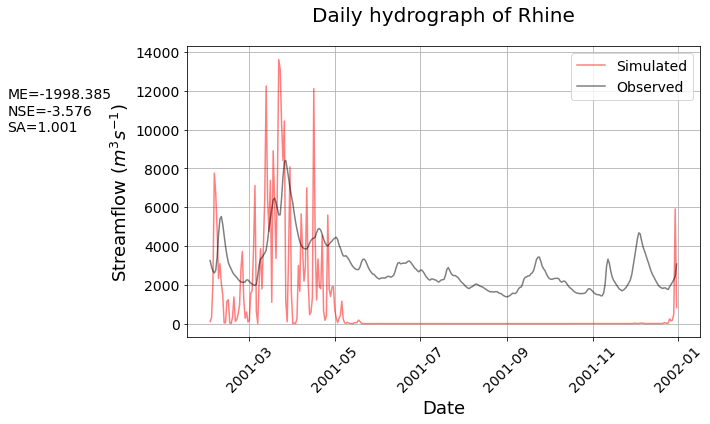

In [24]:
hv.plot(
    discharge[[dataset, "GRDC"]],
    title=f"Daily hydrograph of {catchment}",
    linestyles=["r-", "k-"],
    legend=("Simulated", "Observed"),
    labels=["Date", "Streamflow $\\left(m^{3} s^{-1}\\right)$"],
    metrics=["ME", "NSE", "SA"],
    grid=True,
)
plt.show()